Frame enumuration and submission to Hyp3 with Tropo, Iono, SET corrections.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from s1_frame_enumerator import (get_s1_stack, 
                                 filter_s1_stack_by_geometric_coverage_per_pass, 
                                 get_global_s1_frames, 
                                 get_overlapping_s1_frames, 
                                 enumerate_dates, 
                                 frames2gdf, 
                                 enumerate_gunw_time_series)
from shapely.geometry import Point
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import warnings
import json
import pandas as pd
import datetime

In [3]:
AOI_NAME = 'Saudi-Arabia' #'Los Angeles' # 'Hawaii'
WEATHER_MODEL = None

In [4]:
if WEATHER_MODEL == 'HRRR':
    assert AOI_NAME in ['Maine', 'Bellingham', 'Los-Angeles-0', 
                        'Los-Angeles-1', 'Norfolk', 'Wax-Lake', 'Anchorage',
                        'New-York']

In [5]:
GEO_DICT = {'Los-Angeles-0':  Point(-118, 34).buffer(1),
            'Los-Angeles-1':  Point(-118, 34).buffer(1),
            'Hawaii-0': Point(-155.5, 19.5).buffer(1),
            'Hawaii-1': Point(-155.5, 19.5).buffer(1),
            'Norfolk': Point(-76.5, 36.4).buffer(1),
            'Somalia': Point(41, 1.5).buffer(1),
            'Tibet': Point(92, 41.5).buffer(1),
            'Norway': Point(13, 65).buffer(1),
            'Aleutian': Point(-177, 52).buffer(.25),
            'Wax-Lake': Point(-91.5, 30).buffer(1),
            'Bellingham': Point(-122.5, 48.5).buffer(1),
            'Maine': Point(-69, 47).buffer(1),
            'Anchorage': Point(-150, 61).buffer(1),
            'Chile': Point(-69.0355, -19.449).buffer(2.5),
            'Saudi-Arabia': Point(47.5, 24).buffer(2.5),
            'New-York': Point(-74, 42).buffer(2),
            'Chile-South': Point(-70.5, -54.5).buffer(1)
            }

TRACK_DICT = {'Los-Angeles-0': [64],
              'Los-Angeles-1': [71],
              'Hawaii-0': [124],
              'Hawaii-1': [87],
              'Norfolk': [4],
              'Somalia': [87],
              'Tibet': [48],
              'Norway': [37],
              'Aleutian': [59],
              'Wax-Lake': [63],
              'Bellingham': [137],
              'Maine': [164],
              'Anchorage': [131],
              'Chile': [54],
              'Saudi-Arabia': [72],
              'New-York': [33],
              'Chile-South': [33],
              }

In [6]:
aoi_geo = GEO_DICT[AOI_NAME]
track_numbers = TRACK_DICT[AOI_NAME]

df_aoi = gpd.GeoDataFrame(geometry=[aoi_geo], crs=CRS.from_epsg(4326))

In [7]:
frames = get_overlapping_s1_frames(aoi_geo, track_numbers=track_numbers)

In [8]:
# There will be lots of ways to do this more efficiently i.e. only include frames with overlap of a land mask
# Even to be more confident would likely want some percentage
# Currently, we just shrunk our AOI and excluded a frame
if AOI_NAME == 'Aleutian':
    frames = list(filter(lambda f: f.frame_id!= 9101, frames))

In [9]:
df_frames_all = frames2gdf(frames)
df_frames_all.head()

,frame_id,hemisphere,track_number_min,track_number_max,geometry
0,11105,east,72,72,"POLYGON Z ((46.49422 20.97808 0.00000, 46.4956..."
1,11106,east,72,72,"POLYGON Z ((46.25229 22.13213 0.00000, 46.1808..."
2,11107,east,72,72,"POLYGON Z ((46.00676 23.29743 0.00000, 45.8974..."
3,11108,east,72,72,"POLYGON Z ((45.76008 24.46199 0.00000, 45.5780..."
4,11109,east,72,72,"POLYGON Z ((45.51155 25.62756 0.00000, 45.2894..."


<Axes: >

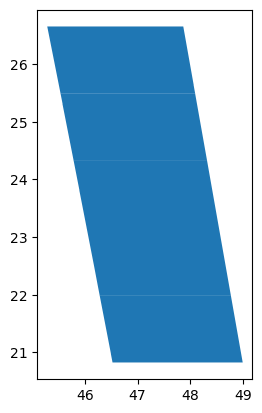

In [10]:
df_frames_all.plot()

/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_17320/2968930518.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


(19.825216043613025, 27.652406967456635)

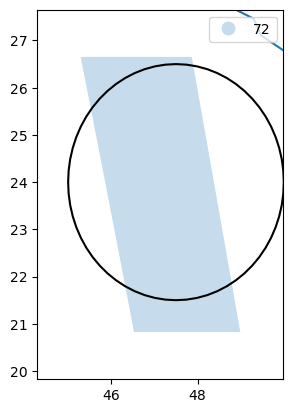

In [11]:
fig, ax = plt.subplots()
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world.boundary.plot(ax=ax)
df_frames_by_track = df_frames_all.dissolve(by='track_number_min').reset_index(drop=False)
df_frames_by_track.plot(ax=ax, 
                        column='track_number_min',
                        categorical=True,
                        alpha=.25, 
                        legend=True)
df_aoi.boundary.plot(ax=ax, edgecolor='black')
xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_17320/1923061845.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


(19.825216043613025, 27.652406967456635)

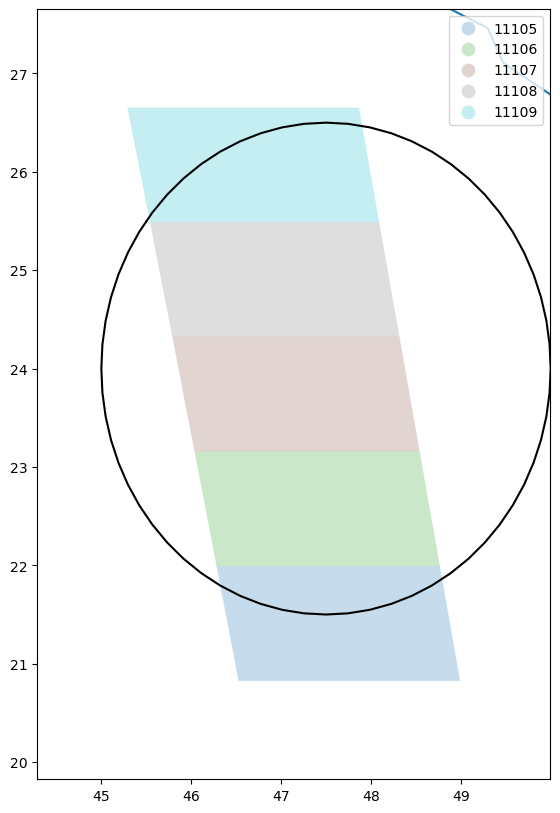

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world.boundary.plot(ax=ax)
df_frames_all.plot(ax=ax, 
                   column='frame_id', 
                   alpha=.25,
                   categorical=True,
                   legend=True)
df_aoi.boundary.plot(ax=ax, edgecolor='black')

xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

# Get Stack from Frame

Here a stack is a list of images with metadata and extents. We note the stack here is not arbitrarily constructed and at some point might be nice to create a simple class to encapsulate it. However, here a stack is one that can be organized to do interferometry over the frames.

1. Per pass coverage $\geq 80$% as it pertains to the frame's coverage geometry
2. Contiguous coverage through frames (determined as Polygon object)

Requires:

1. Frames to be contiguous (otherwise 2. does not make sense)
2. Requires single track or two sequential tracks (we only check if the track numbers are sequential)

In [13]:
df_stack = get_s1_stack(frames)
df_stack.head()

,slc_id,start_time,stop_time,url,track_number,polarization,orbit,beam_mode,size_gb,flight_direction,stack_repeat_pass_id,repeat_pass_timestamp,geometry
0,S1A_IW_SLC__1SDV_20150502T145606_20150502T1456...,2015-05-02 14:56:06.290000+00:00,2015-05-02 14:56:33.232000+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,72,VV+VH,5744,IW,3.928436,ASCENDING,0,2015-05-02 00:00:00+00:00,"POLYGON ((46.32721 21.81393, 46.66942 20.18642..."
1,S1A_IW_SLC__1SDV_20150502T145631_20150502T1456...,2015-05-02 14:56:31.105000+00:00,2015-05-02 14:56:58.055000+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,72,VV+VH,5744,IW,4.308462,ASCENDING,0,2015-05-02 00:00:00+00:00,"POLYGON ((46.01290 23.31356, 46.35763 21.68604..."
2,S1A_IW_SLC__1SDV_20150502T145655_20150502T1457...,2015-05-02 14:56:55.928000+00:00,2015-05-02 14:57:22.872000+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,72,VV+VH,5744,IW,4.459074,ASCENDING,0,2015-05-02 00:00:00+00:00,"POLYGON ((45.69383 24.81193, 46.04131 23.18530..."
3,S1A_IW_SLC__1SDV_20150502T145720_20150502T1457...,2015-05-02 14:57:20.744000+00:00,2015-05-02 14:57:48.659000+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,72,VV+VH,5744,IW,4.337005,ASCENDING,0,2015-05-02 00:00:00+00:00,"POLYGON ((45.35569 26.36773, 45.71914 24.68312..."
4,S1A_IW_SLC__1SDV_20150502T145746_20150502T1458...,2015-05-02 14:57:46.525000+00:00,2015-05-02 14:58:13.476000+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,72,VV+VH,5744,IW,4.176896,ASCENDING,0,2015-05-02 00:00:00+00:00,"POLYGON ((45.02655 27.86441, 45.38127 26.23859..."


# Select N Dates from stack

To make sure there is weather model availability, we are going to truncate the stack to dates on or before `2022-03-01`.

In [14]:
if AOI_NAME == 'Tibet':
    N = 5
else:
    N = 3

# Give ourselves 1 year buffer
MAX_DATE = pd.Timestamp('2022-03-01', tz='UTC')
df_stack_f = df_stack[df_stack.repeat_pass_timestamp <= MAX_DATE]

dates = sorted(df_stack_f.repeat_pass_timestamp.unique(), reverse=True)
df_stack_f = df_stack_f[df_stack_f.repeat_pass_timestamp >= dates[N]].reset_index(drop=True)
df_stack_f.head()

,slc_id,start_time,stop_time,url,track_number,polarization,orbit,beam_mode,size_gb,flight_direction,stack_repeat_pass_id,repeat_pass_timestamp,geometry
0,S1A_IW_SLC__1SDV_20220113T145642_20220113T1457...,2022-01-13 14:56:42.327000+00:00,2022-01-13 14:57:10.234000+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,72,VV+VH,41444,IW,3.685330,ASCENDING,172,2022-01-13 00:00:00+00:00,"POLYGON ((46.38244 21.53804, 46.73652 19.85221..."
1,S1A_IW_SLC__1SDV_20220113T145708_20220113T1457...,2022-01-13 14:57:08.106000+00:00,2022-01-13 14:57:35.067000+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,72,VV+VH,41444,IW,3.907759,ASCENDING,172,2022-01-13 00:00:00+00:00,"POLYGON ((46.06536 23.03783, 46.40988 21.40960..."
2,S1A_IW_SLC__1SDV_20220113T145732_20220113T1457...,2022-01-13 14:57:32.933000+00:00,2022-01-13 14:57:59.890000+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,72,VV+VH,41444,IW,4.117717,ASCENDING,172,2022-01-13 00:00:00+00:00,"POLYGON ((45.74791 24.53688, 46.09512 22.90942..."
3,S1A_IW_SLC__1SDV_20220113T145757_20220113T1458...,2022-01-13 14:57:57.760000+00:00,2022-01-13 14:58:24.710000+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,72,VV+VH,41444,IW,3.949437,ASCENDING,172,2022-01-13 00:00:00+00:00,"POLYGON ((45.42573 26.03497, 45.77603 24.40844..."
4,S1A_IW_SLC__1SDV_20220113T145822_20220113T1458...,2022-01-13 14:58:22.583000+00:00,2022-01-13 14:58:49.533000+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,72,VV+VH,41444,IW,3.792885,ASCENDING,172,2022-01-13 00:00:00+00:00,"POLYGON ((45.09672 27.53205, 45.45068 25.90610..."


# Generate Pairs

In [15]:
min_temporal_baseline = 0
neighbors = 2

data = enumerate_gunw_time_series(df_stack_f, 
                                  min_temporal_baseline, 
                                  n_secondary_scenes_per_ref=neighbors,
                                  frames=frames 
                                 )

Date Pairs: 100%|█████████████████████████████| 5/5 [00:00<00:00, 43.82it/s]


In [16]:
len(data)

25

In [17]:
data[0]

{'reference': ['S1A_IW_SLC__1SDV_20220218T145641_20220218T145709_041969_04FF7E_DFA9',
  'S1A_IW_SLC__1SDV_20220218T145706_20220218T145733_041969_04FF7E_E816'],
 'secondary': ['S1A_IW_SLC__1SDV_20220206T145641_20220206T145709_041794_04F969_C72F',
  'S1A_IW_SLC__1SDV_20220206T145707_20220206T145733_041794_04F969_504D'],
 'reference_date': Timestamp('2022-02-18 00:00:00+0000', tz='UTC'),
 'secondary_date': Timestamp('2022-02-06 00:00:00+0000', tz='UTC'),
 'frame_id': 11105,
 'geometry': <POLYGON Z ((46.494 20.978 0, 46.496 20.978 0, 46.282 21.993 0, 48.767 21.99...>}

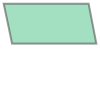

In [18]:
data[0]['geometry']

# Hyp3

In [19]:
TRACKS = ",".join([str(t) for t in TRACK_DICT[AOI_NAME]])
TODAY = datetime.datetime.now().date().strftime('%m%d')
AOI_TOKEN = AOI_NAME.replace(' ', '-')
TOKENS = [t for t in [AOI_TOKEN, TRACKS, WEATHER_MODEL, TODAY] if t]
JOB_NAME = '_'.join(TOKENS)
f'JOB_NAME: {JOB_NAME}'

'JOB_NAME: Saudi-Arabia_72_0830'

In [20]:
f'JOB_NAME character length: {len(JOB_NAME)}'

'JOB_NAME character length: 20'

In [21]:
assert len(JOB_NAME) <= 30

In [22]:
job_parameters =  [{'granules': ifg_data['reference'],
                    'secondary_granules': ifg_data['secondary'],
                   'weather_model': WEATHER_MODEL,
                    'frame_id': ifg_data['frame_id'],
                     } for ifg_data in data]
[params.pop('weather_model') for params in job_parameters if params['weather_model'] is None]
job_parameters[:2]

[{'granules': ['S1A_IW_SLC__1SDV_20220218T145641_20220218T145709_041969_04FF7E_DFA9',
   'S1A_IW_SLC__1SDV_20220218T145706_20220218T145733_041969_04FF7E_E816'],
  'secondary_granules': ['S1A_IW_SLC__1SDV_20220206T145641_20220206T145709_041794_04F969_C72F',
   'S1A_IW_SLC__1SDV_20220206T145707_20220206T145733_041794_04F969_504D'],
  'frame_id': 11105},
 {'granules': ['S1A_IW_SLC__1SDV_20220218T145706_20220218T145733_041969_04FF7E_E816',
   'S1A_IW_SLC__1SDV_20220218T145731_20220218T145758_041969_04FF7E_DA2E'],
  'secondary_granules': ['S1A_IW_SLC__1SDV_20220206T145707_20220206T145733_041794_04F969_504D',
   'S1A_IW_SLC__1SDV_20220206T145731_20220206T145758_041794_04F969_9E84'],
  'frame_id': 11106}]

In [23]:
job_dicts = [{'name': JOB_NAME,
              # NOTE: we are still using the `dev` branch. Change this to "INSAR_ISCE" to use the `main` branch.
              'job_type': 'INSAR_ISCE',
              'job_parameters': parameters
             }
             for parameters in job_parameters]
job_dicts[:2]

[{'name': 'Saudi-Arabia_72_0830',
  'job_type': 'INSAR_ISCE',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20220218T145641_20220218T145709_041969_04FF7E_DFA9',
    'S1A_IW_SLC__1SDV_20220218T145706_20220218T145733_041969_04FF7E_E816'],
   'secondary_granules': ['S1A_IW_SLC__1SDV_20220206T145641_20220206T145709_041794_04F969_C72F',
    'S1A_IW_SLC__1SDV_20220206T145707_20220206T145733_041794_04F969_504D'],
   'frame_id': 11105}},
 {'name': 'Saudi-Arabia_72_0830',
  'job_type': 'INSAR_ISCE',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20220218T145706_20220218T145733_041969_04FF7E_E816',
    'S1A_IW_SLC__1SDV_20220218T145731_20220218T145758_041969_04FF7E_DA2E'],
   'secondary_granules': ['S1A_IW_SLC__1SDV_20220206T145707_20220206T145733_041794_04F969_504D',
    'S1A_IW_SLC__1SDV_20220206T145731_20220206T145758_041794_04F969_9E84'],
   'frame_id': 11106}}]

In [24]:
len(job_dicts)

25

You may want to use `prompt=True` to toggle between Earthdata accounts.

In [28]:
import hyp3_sdk

# uses .netrc; add `prompt=True` to prompt for credentials; 
#hyp3_isce = hyp3_sdk.HyP3('https://hyp3-a19-jpl.asf.alaska.edu')
# hyp3_isce = hyp3_sdk.HyP3('https://hyp3-tibet-jpl.asf.alaska.edu')

## Now test jobs are specified by a separate endpoint (not `job_type`)
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-a19-jpl-test.asf.alaska.edu/')

Uncomment this to submit jobs:

In [26]:
# submitted_jobs = hyp3_isce.submit_prepared_jobs(job_dicts[:])

These are useful snippets to inspect status and view metadata.

In [27]:
jobs = hyp3_isce.find_jobs(name=JOB_NAME)
print(jobs)

25 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 25 pending.


In [28]:
# jobs[0].to_dict()

In [29]:
# successful_jobs = hyp3_isce.find_jobs(name=JOB_NAME, status_code='SUCCEEDED')
# dicts_success = [j.to_dict() for j in successful_jobs]
# dicts_success[:]

In [30]:
# urls = [d['files'][0]['url'] for d in dicts_success]
# urls

In [31]:
# all_jobs = hyp3_isce.find_jobs(name=JOB_NAME)
# dicts_all = [j.to_dict() for j in all_jobs]
# dicts_all[:]

# Failed Jobs and Resubmission

In [32]:
failed_jobs = hyp3_isce.find_jobs(name=JOB_NAME, status_code='FAILED')
dicts_failed = [j.to_dict() for j in failed_jobs]
dicts_failed[:]

[]

In [33]:
JOB_NAME_RESUBMIT = JOB_NAME + '_v2'

In [34]:
job_dicts_resubmit = [{'name': JOB_NAME_RESUBMIT,
                       # NOTE: we are still using the `dev` branch. Change this to "INSAR_ISCE" to use the `main` branch.
                       'job_type': 'INSAR_ISCE_TEST',
                      'job_parameters': d['job_parameters']
                      }
                     for d in dicts_failed[:1]]
job_dicts_resubmit

[]

In [35]:
# submitted_jobs = hyp3_isce.submit_prepared_jobs(job_dicts_resubmit[:])

In [36]:
jobs_v2 = hyp3_isce.find_jobs(name=JOB_NAME_RESUBMIT)
print(jobs_v2)

0 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 0 pending.
